In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from lightning_modules.diffusion_prior import DiffusionPriorTask
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset
from torch2jax import j2t, t2j
import jax.numpy as jnp
import jax
from jax.scipy.special import rel_entr

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mila/l/leo.gagnon/late

In [2]:
task = DiffusionPriorTask('tu3lx093')
task.cuda();

Loaded dataset : (11288/1000)
Loaded checkpoing : last.ckpt
Loaded checkpoing : last.ckpt


In [4]:
dataset = task.val_data.dataset
dataset: LatentDiffusionDataset

In [5]:
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = dataset.__getitems__(torch.arange(500)).values()

In [233]:
xd = 8
cond_mask = torch.BoolTensor([True]*xd + [False]*(50-xd))[None].cuda()

In [6]:
task.diffusion_prior.cfg.sampler = 'ddpm' # ddpm, dpmpp, ddim
task.diffusion_prior.cfg.sampling_timesteps=250

In [14]:
z_t = task.diffusion_prior.sample(100000)
if task.diffusion_prior.cfg.normalize_latent:
    z_t = task.diffusion_prior.unnormalize_latent(z_t)

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

In [15]:
decoded_task_latent = [
    torch.Tensor(
        [
            (latent_embds.weight @ sampled_latent.T).argmax()
            for latent_embds in dataset.known_encoder.latent_embedding
        ]
    )
    for sampled_latent in z_t
]
decoded_task_latent = torch.stack(decoded_task_latent, 0)

In [16]:
decoded_task_id = jnp.stack(
    [
        (
            task.base_task.full_data.index_to_latent
            == t2j(decoded_task_latent[i])
        )
        .all(-1)
        .argmax()
        for i in range(len(decoded_task_latent))
    ]
)

In [17]:
empirical_dist = jnp.bincount(decoded_task_id, minlength=len(task.base_task.full_data))
empirical_dist = empirical_dist/empirical_dist.sum()

8.138020833333333e-05

In [18]:
(empirical_dist == 0.0).sum()

Array(3, dtype=int32)

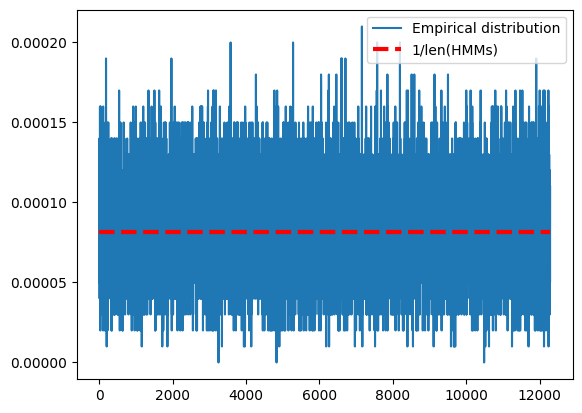

In [32]:
plt.plot(jnp.arange(len(dataset)), empirical_dist, label='Empirical distribution')
plt.hlines(1/len(dataset), 0, len(dataset), linewidth=3, colors='red', linestyles='--', label='1/len(HMMs)')
plt.legend()

In [249]:
oracle_dist = task.base_task.full_data.bayesian_oracle(
    jnp.arange(len(task.base_task.full_data)),
    t2j(cond_input_ids[0]),
)['log_alpha_post']

In [250]:
task.base_task.full_data.index_to_latent[empirical_dist.argsort()[-5:]]

Array([[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [3, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]], dtype=int16)

In [50]:
for id in empirical_dist.nonzero()[0]:
    print(f'HMM {task.base_task.full_data.index_to_latent[id]}, #{id}  : {empirical_dist[id]}')

HMM [0 0 0 0 0 0 0 1 1 1 1 1], #46  : 0.001953125
HMM [0 0 0 0 0 0 1 0 1 0 0 1], #61  : 0.001953125
HMM [0 0 0 0 0 0 1 0 1 0 1 2], #65  : 0.001953125
HMM [0 0 0 0 0 0 1 1 1 1 0 0], #90  : 0.00390625
HMM [0 0 0 0 0 0 1 1 1 1 1 2], #95  : 0.001953125
HMM [0 0 0 0 0 1 0 0 0 0 1 2], #101  : 0.001953125
HMM [0 0 0 0 0 1 0 1 0 1 1 0], #129  : 0.001953125
HMM [0 0 0 0 0 1 1 0 1 0 0 2], #158  : 0.001953125
HMM [0 0 0 0 1 0 0 0 0 1 0 2], #200  : 0.001953125
HMM [0 0 0 0 1 0 0 0 1 1 1 0], #213  : 0.001953125
HMM [0 0 0 0 1 0 1 0 0 0 0 0], #240  : 0.001953125
HMM [0 0 0 0 1 0 1 0 0 0 0 2], #242  : 0.00390625
HMM [0 0 0 0 1 0 1 0 0 1 0 1], #247  : 0.001953125
HMM [0 0 0 0 1 0 1 1 1 1 1 2], #287  : 0.001953125
HMM [0 0 0 0 1 1 0 1 1 0 0 0], #324  : 0.001953125
HMM [0 0 0 0 1 1 1 0 0 1 1 2], #347  : 0.001953125
HMM [0 0 0 1 0 0 0 0 1 1 0 2], #404  : 0.001953125
HMM [0 0 0 1 0 0 0 1 0 1 0 0], #414  : 0.001953125
HMM [0 0 0 1 0 0 1 1 1 0 0 2], #470  : 0.001953125
HMM [0 0 0 1 0 0 1 1 1 1 1 2], #479  :

In [252]:
oracle_ = jnp.exp(oracle_dist[cond_mask.int().argmin().item()+1]).round(2).to_device(jax.devices('cpu')[0])
for id in oracle_.nonzero()[0]:
    print(f'HMM #{id}, {task.base_task.full_data.index_to_latent[id]} : {oracle_[id]}')

HMM #807, [0 0 1 0 0 0 0 1 1 0 1 0] : 0.11999999731779099
HMM #903, [0 0 1 0 0 1 0 1 1 0 1 0] : 0.3799999952316284
HMM #999, [0 0 1 0 1 0 0 1 1 0 1 0] : 0.11999999731779099
HMM #1095, [0 0 1 0 1 1 0 1 1 0 1 0] : 0.3799999952316284


In [253]:
empirical_dist_ = empirical_dist + 1e-8
empirical_dist_ = empirical_dist_/empirical_dist_.sum()
rel_entr(oracle_, empirical_dist_).sum()

Array(7.4462566, dtype=float32)

In [254]:
oracle__ = oracle_ + 1e-8
oracle__ = oracle__/oracle__.sum()
rel_entr(empirical_dist, oracle__).sum()

Array(4.893119, dtype=float32)

In [231]:
emb = nn.ModuleList(
    [
        nn.Embedding(
            n,
            512,
        )
        for n in [5,2,2,3]
    ]
)

In [233]:
directions = orthogonal_(torch.zeros((512,512)))

i = 0
for e in emb:
    weight_ = torch.zeros_like(e.weight)
    for j in range(e.weight.shape[0]):
        weight_[j] = directions[i]
        i += 1
    e.weight = nn.Parameter(weight_)

In [234]:
torch.dot(emb[0].weight[0],emb[0].weight[2])

tensor(-3.0734e-08, grad_fn=<DotBackward0>)

In [217]:
emb[0].weight.shape

torch.Size([5, 512])

In [210]:
torch.dot(a[:,0], a[:,5])

tensor(-8.3819e-09)

In [88]:
true = torch.Tensor(
    [
        (latent_embds.weight @ latent[0].T).argmax()
        for latent_embds in task.base_task.model.encoder.latent_embedding
    ]
)

In [86]:
print(f'Accuracy : {torch.mean(torch.sum(preds == true[None],-1)/len(true))}')

Accuracy : 0.6158332824707031


In [95]:
(torch.sum(preds == true[None],0)/100).mean(0)

tensor(0.6158)

In [93]:
len(preds)

100